### http://www.pnas.org/content/early/2017/01/01/1611675114

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = None

# the API and serialization format totally changed
# from 1 -> 2
import networkx as nx
assert nx.__version__ == '2.1'

from shapely.geometry import Point

import numpy as np

reload(gpd)

<module 'geopandas' from '/home/christian/.miniconda2/envs/datacourse/lib/python2.7/site-packages/geopandas/__init__.pyc'>

### Open demands + stops, clean

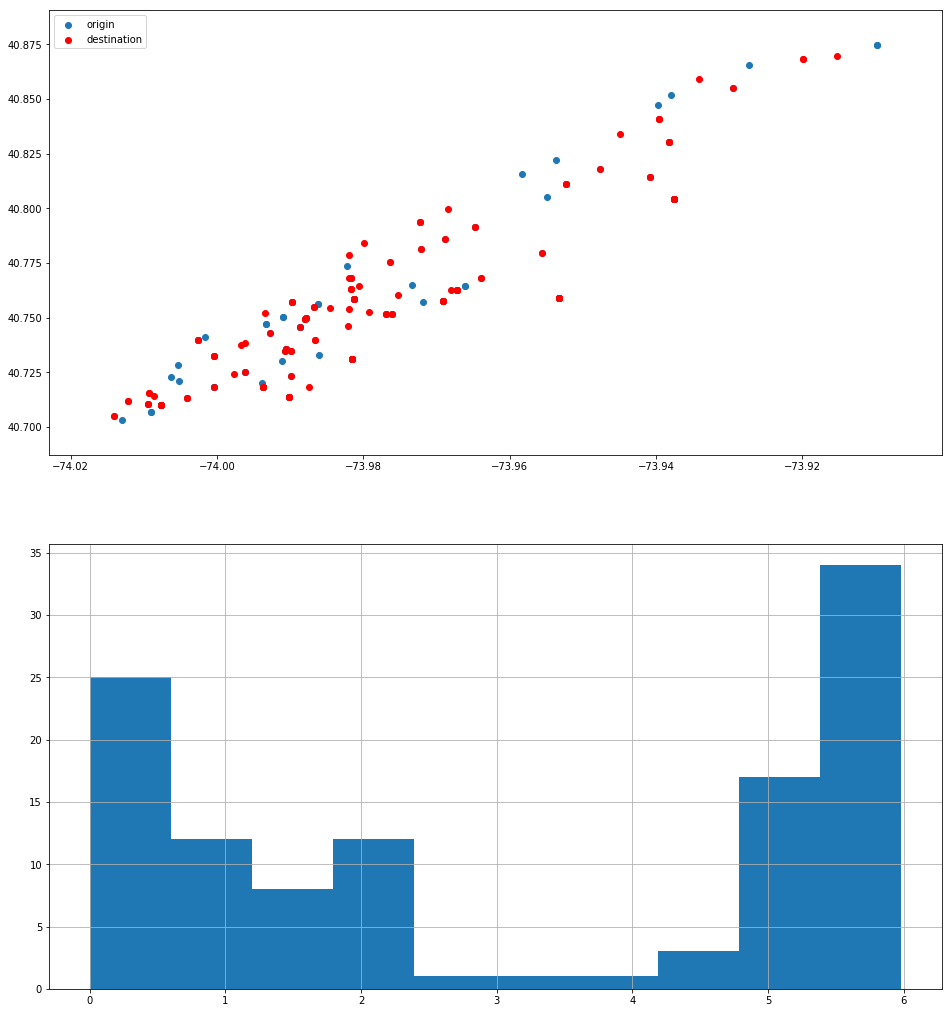

In [2]:
demands = pd.read_pickle("data/nycmtc_final_od.pkl")

demands["mn_O"] = demands["manhattan_path"].apply(lambda x: x[0])
demands["mn_D"] = demands["manhattan_path"].apply(lambda x: x[-1])
demands["mn_O_station"] = demands["mn_O"].apply(lambda x: x.split("-")[0])
demands["mn_D_station"] = demands["mn_D"].apply(lambda x: x.split("-")[0])
demands["demand_time_canonical"] = (demands["TRP_DEP_HR"].apply(lambda x: x - 24 if x > 23 else x)\
                                    + demands["TRP_DEP_MIN"].apply(lambda x: float(x) / 60.))

stops = pd.read_csv("data/mta_gtfs/stops.txt")
stops["geometry"] = stops[["stop_lon", "stop_lat"]].apply(Point, axis=1)
stops["geometry_old"] = stops["geometry"]

stops = gpd.GeoDataFrame(stops).set_index("stop_id")

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))

stops.loc[demands["mn_O_station"]].plot(ax=ax1, label='origin')
stops.loc[demands["mn_D_station"]].plot(ax=ax1, c='red', label='destination')
ax1.legend()

demands["demand_time_canonical"].hist(ax=ax2)

### Open road graph

In [3]:
road_graph = nx.read_gpickle("data/final_graph_1st_pass_nx_2.1.pkl")
lion = gpd.read_file("data/mn_lines.shp")
lion_nodes = gpd.read_file("data/lion/lion.shp/node.shp").to_crs(epsg=4326)

def uniform_str(x):
    strd = str(x)
    while len(strd) < 7:
        strd = '0' + strd
    return strd

lion_nodes["IDSTR"] = lion_nodes["NODEID"].apply(uniform_str)
lion_nodes.set_index("IDSTR", inplace=True, drop=True)

In [4]:
rg_indices = [(e["ix"], e["speed"]) for _, e in road_graph.edges.iteritems()]

In [17]:
lion_only_rg = lion.loc[[r[0] for r in rg_indices]].copy()
lion_only_rg["speed"] = [r[1] for r in rg_indices]
unique_nodes = set(np.concatenate([lion_only_rg["NodeIDFrom"].values, lion_only_rg["NodeIDTo"].values]))
only_rg_nodes = lion_nodes.loc[unique_nodes]
a = len(lion_nodes)
b = len(only_rg_nodes)
print("{}/{} = {}".format(b, a, b/float(a)))
lion_only_rg = lion_only_rg.to_crs(epsg=4326)

12263/131335 = 0.093371911524


In [6]:
stops["geometry"] = stops["geometry_old"].apply(lambda x: x.buffer(.002))
joined_stops = gpd.sjoin(stops, only_rg_nodes)
joined_stops = joined_stops[~joined_stops.index.duplicated(keep='first')]

In [7]:
demands_with_stops = demands.merge(joined_stops, right_index=True, left_on="mn_O_station")\
                            .merge(joined_stops, right_index=True, left_on="mn_D_station", suffixes=("_o", "_d"))
demands_with_stops = gpd.GeoDataFrame(demands_with_stops)
print len(demands)
print len(demands_with_stops)

114
104


### Compute Skim Graph

In [8]:
print road_graph.edges[(u'9000428', u'0021076')]
for k, v in road_graph.edges.iteritems():
    v['weight'] = 60. * v['dist'] / v['speed']
print road_graph.edges[(u'9000428', u'0021076')]


{'speed': 6.207146688449705, 'dist': 0.11436198655596957, 'weight': 0.7098616261354163, 'ix': 9285}
{'speed': 6.207146688449705, 'dist': 0.11436198655596957, 'weight': 1.1054546537665209, 'ix': 9285}


In [12]:
# import joblib
# def process_g(ix1, ix2, s1, s2):
#     l = nx.algorithms.shortest_path_length(road_graph, 
#                                            s1["index_right"],
#                                            s2["index_right"])
#     return (ix1, ix2, l)
            
# g = (joblib.delayed(process_g)(ix1, ix2, s1, s2)\
#      for ix1, s1 in joined_stops.iterrows()\
#      for ix2, s2 in joined_stops.iterrows())

# p = joblib.Parallel(n_jobs=4)(g)

# skim_graph = nx.DiGraph()
# for ix1, ix2, t in p:
#     skim_graph.add_edge(ix1, ix2, weight=t)

# nx.write_gpickle(skim_graph, "data/skim_graph_20170425.pkl")

skim_graph = nx.read_gpickle("data/skim_graph_20170425.pkl")

## Last step: simulation

In [13]:
def memoize(f):
    """ Memoization decorator for functions taking one or more arguments. """
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
    return memodict(f)

In [42]:
from itertools import permutations, chain


VEHICLE_CAPACITY = 4
N_VEHICLES = 100

# maximum waiting time, mins
OMEGA = 30.

# maximum travel delay, mins
DELTA = 30.

@memoize
def time_to_stop(x, y, stop):
    pos = Point(x, y)
    nearest_node =  only_rg_nodes["geometry"].distance(pos).idxmin()
    shortest_path = nx.algorithms.shortest_path(road_graph, nearest_node, stop)
    return shortest_path, sum(road_graph[n1][n2]['weight'] for n1, n2 in zip(shortest_path, shortest_path[1:]))

# testing
# args = ({"cur_xy": [only_rg_nodes["geometry"][0].x, only_rg_nodes["geometry"][0].y]},'0066084')
# path, t = time_to_stop(*args)
def travel(t, vehicle, requests):
    """
    As per alonso-mora paper
    
    requests: (o, d, t) tuples
    """
    dropoffs = ((p, 'd') for p in vehicle['passengers'] + requests)
    pickups = ((p, 'p') for p in requests)
    
    best_order = None
    min_cost = None
    # TODO: parallelize
    for pd_order in permutations(chain(pickups, dropoffs)):
        if not legal(pd_order, 
                     len(vehicle["passengers"]), 
                     vehicle["capacity"]):
            continue
        first_stop = pd_order[0][0][0] if pd_order[0][1] == 'p' else pd_order[0][0][1]
        first_rg_node = joined_stops.loc[first_stop]["index_right"]
        path_to_first, time_to_first = time_to_stop(vehicle["cur_xy"].x, 
                                                    vehicle["cur_xy"].y, 
                                                    first_rg_node)
        #vehicle_cost = time_to_first + sum(skim_graph[a][b] for a, b in zip(pd_order, pd_order[1:]))
        cost = compute_cost(t, time_to_first,
                            pd_order)
        if cost == -1:
            continue
            
        if not min_cost or cost < min_cost:
            order = [p.o if pord == 'p' else p.d for p, pord in pd_order]
            min_cost = cost
            best_order = pd_order
    return min_cost, best_order

def legal(pd_order, n_passengers, capacity):
    indices_by_passenger = defaultdict(dict)
    cur_count = n_passengers
    for i, (passenger, p_or_d) in enumerate(pd_order):
        indices_by_passenger[passenger][p_or_d] = i
        cur_count += (1 if p_or_d == 'p' else -1)
        if cur_count > capacity:
            return False
    for indices in indices_by_passenger.itervalues():
        if 'p' in indices and indices['p'] > indices['d']:
            return False
    return True

from collections import defaultdict
def compute_cost(t, time_to_first, pd_order):
    costs_by_passenger = defaultdict(dict)
    cur_time = t
    cur_stop = None
    passenger, p_or_d = pd_order[0]
    ttf = timedelta(minutes=time_to_first)
    if p_or_d == 'p':            
        costs_by_passenger[passenger]['pickup_time'] = t + ttf
        cur_stop = passenger[0]
    elif p_or_d == 'd':
        costs_by_passenger[passenger]['dropoff_time'] = t + ttf
        cur_stop = passenger[1]
        
    cur_time = t + ttf
    for (passenger, p_or_d) in pd_order[1:]:
        if p_or_d == "p":
            key = "pickup_time"
            od = 0 
        else:
            key = "dropoff_time"
            od = 1
        next_stop = passenger[od]
        ttn = timedelta(minutes=skim_graph[cur_stop][next_stop]['weight'])
        next_time = cur_time + ttn
        costs_by_passenger[passenger][key] = next_time
        cur_stop = next_stop
        cur_time = next_time
    total_cost = 0
    for passenger, cost in costs_by_passenger.iteritems():
        if "pickup_time" in cost and cost["pickup_time"] > passenger.tpl:
            return -1
        elif cost["dropoff_time"] > passenger.t_star:
            return -1
        sub_value = cost["pickup_time"] if "pickup_time" in cost else t
        total_cost += (cost["dropoff_time"] - sub_value).total_seconds() / 60.
    #return costs_by_passenger
    return total_cost

def check_rr_edge(t, r1, r2, v):
    a, b = travel(t, v, [r1, r2])
    if not a:
        return False
    return a

# at: arrival time of vehicle
c1 = lambda r, at: r[2] + OMEGA <= at
# tt: travel time for request
c2 = lambda r, tt: skim_graph[r[0]][r[1]] + DELTA <= tt
# make sure theres room for another dood
c3 = lambda v: len(v["passengers"]) + 1 <= v["CAPACITY"]

def check_rv_edge(t, v, r):
    a, b = travel(t, v, [r])
    if not a:
        return False
    return a

def gen_rv_graph(t, requests, vehicles):
    rv_g = nx.Graph()
    rr_g = nx.Graph()
    for r1 in requests:
        for i, v in vehicles:
            a = check_rv_edge(t, v, r1)
            if a:
                rv_g.add_edge(r1, i, weight=a)
        
        stop = joined_stops.loc[r1.o]
        x, y = stop["geometry_old"].x, stop["geometry_old"].y
        fake_vehicle = init_vehicle(x, y)
        for r2 in requests:
            a = check_rr_edge(t, r1, r2, fake_vehicle)
            if a:
                rr_g.add_edge(r1, r2, weight=a)
    return rr_g, rv_g
        
from collections import namedtuple
Passenger = namedtuple("Passenger", ["o", "d", "t", "tpl", "t_star"])
Passenger.__str__ = lambda p: p.o + "-" + p.d
Passenger.__repr__ = lambda p: p.o + "-" + p.d

def init_passenger(o, d, t):
    try:
        shortest = skim_graph[o][d]['weight']
    except:
        print o
        print d
        raise
    return Passenger(o, d, t, t + timedelta(minutes=OMEGA), 
                     t + timedelta(minutes=(shortest + DELTA)))

def init_vehicle(x, y):
    BASE_VEHICLE = {"capacity": VEHICLE_CAPACITY,
                    "passengers": [],
                    "cur_xy": Point(x, y),
                    "dest_node": 0,
                    "latest_node": "0",
                    "next_node": "-1",
                    "cur_route": [],
                    "ridership_history": []} # tuples of the form (start_t, end_t, n)
    
    return BASE_VEHICLE.copy()

from datetime import datetime, timedelta

t = datetime.now()
V = [(i, init_vehicle(-74, 40)) for i in xrange(N_VEHICLES)]

passengers = [init_passenger(d["mn_O_station"], d["mn_D_station"], t)\
              for _, d in demands_with_stops.iterrows() if d["index_right_o"] != d["index_right_d"]]

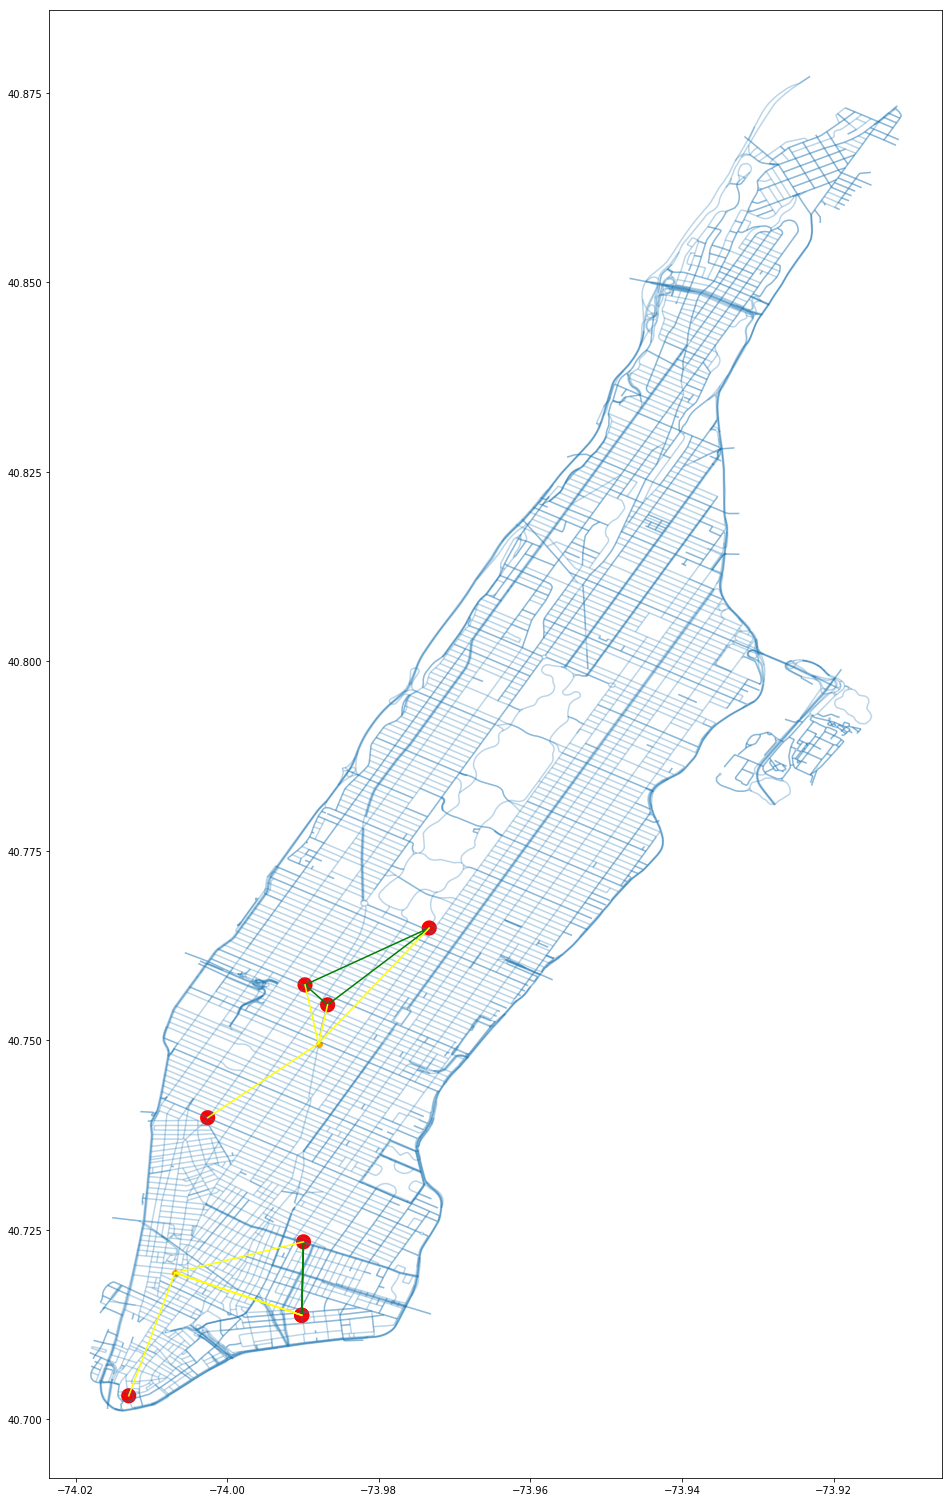

In [43]:
# TEST AREA
stops["geometry"] = gpd.GeoSeries(stops["geometry_old"]).buffer(.001)
joined_stops["geometry"] = joined_stops["geometry_old"]
v = init_vehicle(stops.loc["R17S"]["geometry_old"].x, 
                 stops.loc["R17S"]["geometry_old"].y)
v2 = init_vehicle(stops.iloc[100]["geometry_old"].x,
                  stops.iloc[100]["geometry_old"].y)
vehicles = [(0, v), (1, v2)]
d = passengers[0]
d2 = passengers[1]
ds = passengers[0:10]
# ax = joined_stops.plot(figsize=(16, 40))
# lion_only_rg.to_crs(epsg=4326).plot(ax=ax, alpha=.3)
# stops.loc[["R17S"]].plot(ax=ax, color='orange')
# stops.iloc[[100]].plot(ax=ax, color="orange")
# for d in ds:
#     stops.loc[[d.o]].plot(ax=ax, color='red')
#     stops.loc[[d.d]].plot(ax=ax, color='green')

#stops.loc[[d.o, d.d]].plot(ax=ax, color='red')
#stops.loc[[d2.o, d2.d]].plot(ax=ax, color='yellow', alpha=1)
#only_rg_nodes.loc[path].plot(ax=ax, color='yellow')
costs_by_passenger = travel(t, v, [d, d2])
costs_by_passenger
g1, g2 = gen_rv_graph(t, ds, [(0, v),
                              (1, v2)])
rr_g, rv_g = g1, g2
#lion_only_rg = lion_only_rg.to_crs(epsg=4326)
def plot_rv_graph(rr_g, rv_g, vehicles, stops):
    ax = lion_only_rg.plot(alpha=.3, figsize=(16, 40))
    stops.loc[[n.o for n in rr_g.nodes]].plot(color='red', ax=ax)
    vehicles_by_index = dict(vehicles)
    for ix, v in vehicles:
        plt.scatter([v["cur_xy"].x], [v["cur_xy"].y], color='orange', s=36)
    for p1, p2 in rr_g.edges.iterkeys():
        xs = gpd.GeoSeries(stops.loc[[p1.o, p2.o]].geometry_old).x
        ys = gpd.GeoSeries(stops.loc[[p1.o, p2.o]].geometry_old).y
        plt.plot(xs, ys, color='green')
    for v, p in rv_g.edges.iterkeys():
        if isinstance(p, int):
            p, v= v, p
        vehicle = vehicles_by_index[v]
        plt.plot([vehicle["cur_xy"].x, stops.loc[p.o].geometry_old.x],
                 [vehicle["cur_xy"].y, stops.loc[p.o].geometry_old.y],
                 color='yellow')
plot_rv_graph(rr_g, rv_g, vehicles, stops)

In [44]:
from itertools import izip, combinations

   
def gen_rtv(t, vehicles, rv_g, rr_g):
    rtv_g = nx.Graph()
    Tks_for_vehicle = []
    for i, v in vehicles:
        rv_edges = rv_g.edges(i)
        Tk =[]
        # trips of size 1
        Tk.append([])
        for (k, r) in rv_edges:
            if isinstance(r, int):
                r, k = k, r
            T = tuple([r])
            rtv_g.add_edge(r, T)
            rtv_g.add_edge(T, i, weight=rv_g.edges[(k, r)]['weight'])
            Tk[0].append(T)
        
        # trips of size 2
        Tk.append([])
        for j, (r1, ) in enumerate(Tk[0]):
            for (r2, ) in Tk[0][j+1:]:
                #return r1, r2
                T = (r1, r2)
                if T not in rr_g.edges:
                    continue
                a, b = travel(t, v, list(T))
                if a:
                    Tk[1].append(T)
                    rtv_g.add_edge(T, i, weight=a)
                    rtv_g.add_edge(r1, T)
                    rtv_g.add_edge(r2, T)
        # trips of size N
        for k in range(2, v["capacity"]):
            Tk.append([])
            for j, t1 in enumerate(Tk[k - 1]):
                for t2 in Tk[k-1][j + 1:]:
                    U = set(t1).union(set(t2))
                    if len(U) != k + 1:
                        continue
                    if not check_subtrips(U, Tk[k-1]):
                        continue
                    canonical = sorted(tuple(U))
                    a, b = travel(t, v, list(canonical))
                    if not a:
                        continue
                    Tk[-1].append(canonical)
                    for r_i in canonical:
                        rtv_g.add_edge(r_i, canonical)
                    rtv_g.add_edge(canonical, v, weight=a)
        Tks_for_vehicle.append(Tk)
    print Tks_for_vehicle
    return sum((list(x) for x in zip(*Tks_for_vehicle)), []), rtv_g
def check_subtrips(U, tk):
    tk = set(tuple(sorted((t))) for t in tk)
    #print tk
    for trip in U:
        if tuple(sorted(tuple((U - set(trip))))) not in tk:
            return False
    return True

T, g4 = gen_rtv(t, [(0, v), (1, v2)], rv_g, rr_g)
    
#nx.draw(g3, pos=pos, with_labels=True)

[[[(L01S-L06S,), (R13S-R11S,), (R16S-R11S,), (A27N-F11N,)], [(R13S-R11S, R16S-R11S), (R13S-R11S, A27N-F11N), (R16S-R11S, A27N-F11N)], [], []], [[(F16N-L06S,), (F14N-F16N,), (F16N-D20N,), (F16N-629S,), (R27N-R11N,)], [(F16N-L06S, F14N-F16N), (F16N-L06S, F16N-D20N), (F16N-L06S, F16N-629S), (F14N-F16N, F16N-D20N), (F14N-F16N, F16N-629S)], [], []]]


## TODO: MAKE SURE THE SAME OUTPUT HAPPENS ON THE COMMAND LINE
## THEN, MOVE TO THE COMMAND LINE

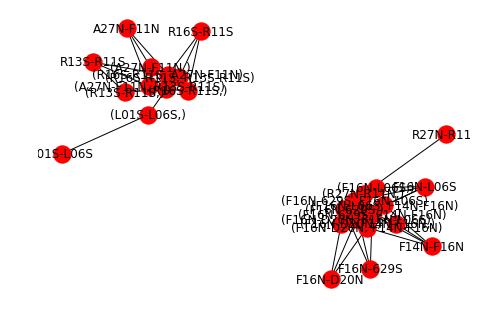

In [24]:
nx.draw(g4, with_labels=True)

In [66]:
g3.edges([0])

EdgeDataView([(0, (A27N-F11N,)), (0, (R13S-R11S,)), (0, (L01S-L06S,)), (0, (R13S-R11S, A27N-F11N)), (0, (A27N-F11N, R16S-R11S)), (0, (R13S-R11S, R16S-R11S)), (0, (R16S-R11S,))])

In [45]:
def greedy_assign(rtvg, T):
    R_ok = set()
    V_ok = set()
    assignment = set()
    for k, Tk in zip(range(len(T), 0, -1), T[::-1]):
        if not Tk:
            continue
        print Tk
        print rtvg.edges(Tk)
        Sk = sorted((e for e in rtvg.edges(Tk) if isinstance(e[1], int) or isinstance(e[0], int)),
                    key=lambda e: rtvg.edges[e]["weight"])
        print Sk
        print "=" * 10
        for trip, v in Sk:
            if np.any([t in R_ok for t in trip]):
                continue
            if v in V_ok:
                continue
            [R_ok.add(t) for t in trip]
            assignment.add((trip, v))
            V_ok.add(v)
    return assignment
assignment = greedy_assign(g4, T)

[(F16N-L06S, F14N-F16N), (F16N-L06S, F16N-D20N), (F16N-L06S, F16N-629S), (F14N-F16N, F16N-D20N), (F14N-F16N, F16N-629S)]
[((F16N-L06S, F14N-F16N), F16N-L06S), ((F16N-L06S, F14N-F16N), 1), ((F16N-L06S, F14N-F16N), F14N-F16N), ((F16N-L06S, F16N-D20N), F16N-L06S), ((F16N-L06S, F16N-D20N), 1), ((F16N-L06S, F16N-D20N), F16N-D20N), ((F16N-L06S, F16N-629S), F16N-L06S), ((F16N-L06S, F16N-629S), 1), ((F16N-L06S, F16N-629S), F16N-629S), ((F14N-F16N, F16N-D20N), 1), ((F14N-F16N, F16N-D20N), F16N-D20N), ((F14N-F16N, F16N-D20N), F14N-F16N), ((F14N-F16N, F16N-629S), 1), ((F14N-F16N, F16N-629S), F16N-629S), ((F14N-F16N, F16N-629S), F14N-F16N)]
[((F16N-L06S, F14N-F16N), 1), ((F14N-F16N, F16N-D20N), 1), ((F16N-L06S, F16N-D20N), 1), ((F14N-F16N, F16N-629S), 1), ((F16N-L06S, F16N-629S), 1)]
[(R13S-R11S, R16S-R11S), (R13S-R11S, A27N-F11N), (R16S-R11S, A27N-F11N)]
[((R13S-R11S, R16S-R11S), 0), ((R13S-R11S, R16S-R11S), R13S-R11S), ((R13S-R11S, R16S-R11S), R16S-R11S), ((R13S-R11S, A27N-F11N), 0), ((R13S-R11S

In [47]:
assignment

{((F16N-L06S, F14N-F16N), 1), ((R13S-R11S, R16S-R11S), 0)}

In [52]:
joined_stops.head(1)

,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry,geometry_old,index_right,NODEID,VIntersect
107,NaN,215 St,NaN,40.869444,-73.915279,NaN,NaN,1,NaN,POINT (-73.915279 40.869444),POINT (-73.915279 40.869444),0044643,44643,


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 14))
ax = ax1
lion_only_rg.plot(ax=ax, alpha=.2)
for trips, vehicle in assignment:
    vehicle = vehicles[vehicle][1]
    ax.scatter([vehicle['cur_xy'].x], [vehicle['cur_xy'].y], color='orange', s=40)
    for trip in trips:
        stops.loc[[trip.o]].plot(ax=ax, color='red')
        ax.plot([vehicle['cur_xy'].x, stops.loc[trip.o].geometry.centroid.x],
                [vehicle['cur_xy'].y, stops.loc[trip.o].geometry.centroid.y],
                color='yellow')
ax = ax2
lion_only_rg.plot(ax=ax2, alpha=.2)

    
def plot_path(v, path, road_graph, joined_stops, ax, lion_only_rg):
    first_stop = path[0][0].o if path[0][1] == 'p' else path[0][0].d
    first_node = joined_stops.loc[first_stop].index_right
    route,time = time_to_stop(v["cur_xy"].x, 
                       v["cur_xy"].y, 
                       first_node)
    origins = route[:-1]
    destinations = route[1:]
    for ori, des in zip(origins, destinations):
        lion_only_rg[(lion_only_rg["NodeIDFrom"] == ori) & (lion_only_rg["NodeIDTo"] == des)].plot(ax=ax, color='red')
    cur_stop = first_stop
    cur_node = first_node
    for nex, p_or_d in path[1:]:
        if p_or_d == 'p':
            next_stop = nex.o
        else:
            next_stop = nex.d
        next_node = joined_stops.loc[next_stop].index_right
        route = nx.algorithms.shortest_path(road_graph, cur_node, next_node)
        if len(route) == 1:
            continue
        origins = route[:-1]
        destinations = route[1:]
        try:
            for o, d in zip(origins, destinations):
                lion_only_rg[(lion_only_rg["NodeIDFrom"] == ori) & (lion_only_rg["NodeIDTo"] == des)].plot(ax=ax, color='red')
        except:
            print origins
            print destinations
            print "===="
            raise
        cur_node = next_node
        cur_stop = next_stop
    
for trips, vehicle in assignment:
    v = vehicles[vehicle][1]
    ax.scatter([v['cur_xy'].x], [v['cur_xy'].y], color='orange', s=40)
    stops.loc[[s.o for s in trips]].plot(ax=ax, color='red')
    stops.loc[[s.d for s in trips]].plot(ax=ax, color='green')
    time, path = travel(t, v, list(trips))
    print plot_path(v, path, road_graph, joined_stops, ax, lion_only_rg)
    

0020199
0065999
0065999
0020204
0020204
0020193
0020193
0020217
0020217
0020360
0020360
0020365
0020365
0020357
0020357
0020359
0020359
0020476
0020476
0020481
0020481
0020484
0020484
0020485
0020485
0020566
0020566
0020568
0020568
0020578
0020578
0020581
0020581
0020574
0020574
0020671
0020671
0103070
0103070
0020673
0020673
0078162
0078162
0020687
0020687
0020688
0020688
9051998
9051998
0078069
0078069
0078070
0078070
0078379
0078379
0087984
0087984
0092927
0092927
0087985
None
0021390
0021392


KeyboardInterrupt: 

In [78]:
lion_only_rg[lion_only_rg["NodeIDFrom"] == '0020199'].head()

,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,FaceCode,SeqNum,StreetCode,SAFStreetC,LGC1,LGC2,LGC3,LGC4,LGC5,LGC6,LGC7,LGC8,LGC9,BOE_LGC,SegmentID,SegCount,LocStatus,LZip,RZip,LBoro,RBoro,L_CD,R_CD,LATOMICPOL,RATOMICPOL,LCT2010,LCT2010Suf,RCT2010,RCT2010Suf,LCB2010,LCB2010Suf,RCB2010,RCB2010Suf,LCT2000,LCT2000Suf,RCT2000,RCT2000Suf,LCB2000,LCB2000Suf,RCB2000,RCB2000Suf,LCT1990,LCT1990Suf,RCT1990,RCT1990Suf,LAssmDist,LElectDist,RAssmDist,RElectDist,SplitElect,LSchlDist,RSchlDist,SplitSchl,LSubSect,RSubSect,SanDistInd,MapFrom,MapTo,BoroBndry,MH_RI_Flag,XFrom,YFrom,XTo,YTo,ArcCenterX,ArcCenterY,CurveFlag,Radius,NodeIDFrom,NodeIDTo,NodeLevelF,NodeLevelT,ConParity,Twisted,RW_TYPE,PhysicalID,GenericID,NYPDID,FDNYID,LBlockFace,RBlockFace,LegacyID,Status,StreetWidt,StreetWi_1,StreetWi_2,BikeLane,BIKE_TRAFD,ACTIVE_FLA,POSTED_SPE,Snow_Prior,Number_Tra,Number_Par,Number_Tot,Carto_Disp,FCC,ROW_Type,LLo_Hyphen,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Leng,index_righ,BoroCode,BoroName,Shape_Le_1,Shape_Area,geometry,speed
5574,VARICK STREET,,0,U,,B,,A,DOT,,4535,00010,132685,,01,,,,,,,,,1,0031789,1,,10013,10013,1,1,101,101,308,307,33,,33,,3015,,3016,,33,,33,,3016,,3017,,33,,33,,66,009,66,009,,02,02,,3B,,,12A,12A,,,982327,201274,982363,201511,0,0,,0,0020199,0020200,M,M,,,1,733,611,,,1222604545,1222601418,0031789,2,58.0,58.0,,2,TF,,25,C,3,2,5,,,,1,13,2,10,1,13,2,10,1453501000000,239.757621,1,1,Manhattan,361657.416718,6.366004e+08,LINESTRING (-74.00693633811085 40.719126655592...,3.990069
12901,FRANKLIN STREET,,0,U,,B,,A,DOT,,2540,01020,120890,,01,,,,,,,,,1,0031788,1,,10013,10013,1,1,101,101,325,308,33,,33,,3019,,3015,,33,,33,,3019,,3016,,33,,33,,66,009,66,009,,02,02,,3B,3B,,12A,12A,,,982327,201274,981839,201336,0,0,,0,0020199,0020068,M,M,,,1,948,815,,,1222602725,1222606581,0031788,2,34.0,35.0,,,,,25,C,1,2,3,,,,129,165,132,166,129,165,132,166,1254001000000,492.597636,1,1,Manhattan,361657.416718,6.366004e+08,LINESTRING (-74.00693633811085 40.719126655592...,4.511041


In [ ]:
(.12 / 8.9) * 60

In [ ]:
args = (only_rg_nodes["geometry"][0].x, only_rg_nodes["geometry"][0].y,'0066084')
path, t = time_to_stop(*args)
t

In [ ]:
max(passengers, key=lambda p: p["fastest_time"])

In [ ]:
ax = only_rg_nodes.plot(figsize=(16, 40))
p = nx.algorithms.shortest_path(road_graph, *['0044346', '0066084'])
only_rg_nodes.loc[p].plot(ax=ax, color='red0')

In [ ]:
ax = lion_only_rg.to_crs(epsg=4326).plot(figsize=(16, 40), alpha=.5)
demands_with_stops["geometry"] = demands_with_stops["geometry_old_d"]
demands_with_stops.plot(ax=ax, color='blue')
demands_with_stops["geometry"] = demands_with_stops["geometry_old_o"]
demands_with_stops.plot(ax=ax, color='red')


In [ ]:
lion_only_rg["log_speed"] = lion_only_rg["speed"].apply(np.log)

In [ ]:
lion_only_rg[lion_only_rg["log_speed"] < 40]\
.plot("log_speed", figsize=(16, 40), colormap='inferno')

In [ ]:
# TEST AREA
lion_4326 = lion_only_rg.to_crs(epsg=4326)
stops["geometry"] = gpd.GeoSeries(stops["geometry_old"]).buffer(.0012)
v = init_vehicle(stops.loc["R17S"]["geometry_old"].x, 
                 stops.loc["R17S"]["geometry_old"].y)
d = passengers[0]
d2 = passengers[1]
joined_stops["geometry"] = joined_stops["geometry_old"]

#ax = joined_stops.plot(figsize=(16, 40))
ax = lion_4326.plot(figsize=(16, 40), alpha=.2)
stops.loc[["R17S"]].plot(ax=ax, color='green')
stops.loc[[d.o, d.d]].plot(ax=ax, color='red')
stops.loc[[d2.o, d2.d]].plot(ax=ax, color='yellow', alpha=1)
ax.set_ylim([40.73, 40.77])
ax.set_xlim([-74.01, -73.96])
#only_rg_nodes.loc[path].plot(ax=ax, color='yellow')
costs_by_passenger = travel(t, v, [d, d2])
costs_by_passenger


In [ ]:
nx.draw(g2, with_labels=True)

In [ ]:
# TEST AREA
lion_4326 = lion_only_rg.to_crs(epsg=4326)
stops["geometry"] = gpd.GeoSeries(stops["geometry_old"]).buffer(.0012)
v = init_vehicle(stops.loc["R17S"]["geometry_old"].x, 
                 stops.loc["R17S"]["geometry_old"].y)
d = passengers[0]
d2 = passengers[1]
joined_stops["geometry"] = joined_stops["geometry_old"]

#ax = joined_stops.plot(figsize=(16, 40))
ax = lion_4326.plot(figsize=(16, 40), alpha=.2)
stops.loc[["R17S"]].plot(ax=ax, color='green')
stops.loc[[dw.o, d.d]].plot(ax=ax, color='red')
stops.loc[[d2.o, d2.d]].plot(ax=ax, color='yellow', alpha=1)
ax.set_ylim([40.73, 40.77])
ax.set_xlim([-74.01, -73.96])
ax.plot([v['cur_xy'].centroid.x, stops.loc[d.o].geometry.centroid.x],
        [v['cur_xy'].centroid.y, stops.loc[d.o].geometry.centroid.y],
        'r-')
ax.plot([v['cur_xy'].centroid.x, stops.loc[d2.o].geometry.centroid.x],
        [v['cur_xy'].centroid.y, stops.loc[d2.o].geometry.centroid.y],
        'r-')
ax.plot([stops.loc[d.o].geometry.centroid.x, stops.loc[d2.o].geometry.centroid.x],
        [stops.loc[d.o].geometry.centroid.y, stops.loc[d2.o].geometry.centroid.y],
        'o-')

In [60]:
df = pd.DataFrame()
df.to_csv("hi")

In [62]:
!rm hi